file sizes in directory /mnt/bigdata/placenta/wsi
20230810_140324._a.tiff 2.48 GB
20230815_095205_a.tiff 8.55 GB
20230817_115418_a.tiff 3.83 GB
20230817_115911_b.tiff 3.87 GB
20230817_120323_b.tiff 5.80 GB
20230817_133806_b.tiff 7.19 GB
20230817_134937_a.tiff 2.53 GB
20230817_135246_a.tiff 2.68 GB
20230817_135702_a.tiff 6.07 GB
20230817_135910_b.tiff 4.99 GB
DEBUG added label wsi_name 20230810_140324 and label class 1 to /mnt/bigdata/placenta/wsi/20230810_140324._a.tiff
DEBUG added label wsi_name 20230815_095205_a and label class 1 to /mnt/bigdata/placenta/wsi/20230815_095205_a.tiff
DEBUG added label wsi_name 20230817_115418_a and label class 1 to /mnt/bigdata/placenta/wsi/20230817_115418_a.tiff
DEBUG added label wsi_name 20230817_115911_b and label class 0 to /mnt/bigdata/placenta/wsi/20230817_115911_b.tiff
DEBUG added label wsi_name 20230817_120323_b and label class 0 to /mnt/bigdata/placenta/wsi/20230817_120323_b.tiff
DEBUG added label wsi_name 20230817_133806_b and label class 0 to

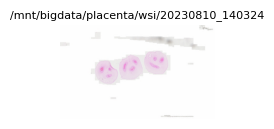

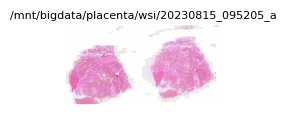

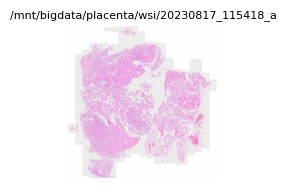

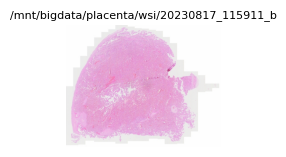

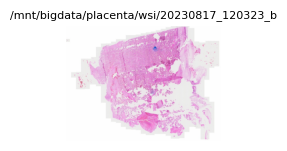

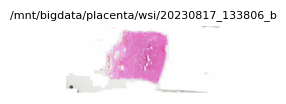

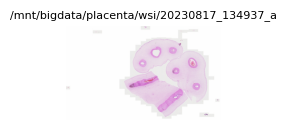

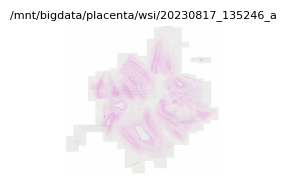

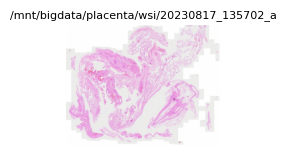

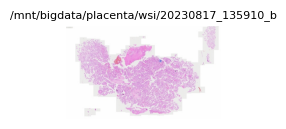

In [1]:
##########################################################################################################
# Author: Mihaly Sulyok & Peter Karacsonyi                                                               #
# Last updated: 2024 jan 4                                                                               #
# This workbook does wsi preprocessing with Pathml version 2.1.1                                         #
# Input: wsi image files, tested with OpenSlide .tif                                                     #
# Transformations: MedianBlur, BinaryThreshold, Tiling, MorphOpen, MorphClose, ForegroundDetection       #
# Read more on transformations: https://pathml.readthedocs.io/en/latest/examples/link_gallery.html       #
# Output: h5path files (https://pathml.readthedocs.io/en/latest/h5path.html)                             #
##########################################################################################################

# local imports
import lib
import os
if os.name == 'nt':
    import helpers.openslideimport #on windows, openslide needs to be installed manually, check local openslideimport.py

# global imports
import time
from pathlib import Path
import matplotlib.pyplot as plt

# pathml imports
from pathml import types
from pathml.core import SlideData, SlideDataset
from pathml.preprocessing import Pipeline, TissueDetectionHE

#########
# usage #
#########

#####################
# configure folders #
#####################

# set working directory
base_dir = Path("/mnt/bigdata/placenta") # "/mnt/g/xyz/" for linux
# wsi folder
wsi_subfolder = "wsi"
# place geojsons into this folder inside base with same name as the image (echino23.tiff / echino23.gejson)
annotations_subfolder = "annotations"
# output h5path files to (will be created)
h5path_subfolder = "h5"
# filenames having this substring with endpoint
endpoint_filename = "a"

#######################################
# configure transformation parameters #
#######################################

pipeline = Pipeline([
    # values are the best found for placenta wsis
    TissueDetectionHE(
        mask_name = "tissue", 
        threshold = 19,
        min_region_size=1000,
        outer_contours_only=False,
        max_hole_size = 10000,
        use_saturation=True
    )
])

# relative directory generation (don't modify)
data_dir = base_dir / Path(wsi_subfolder)                       # input
h5_dir = base_dir / Path(h5path_subfolder)                      # output
h5_dir.mkdir(0o644, parents=True, exist_ok=True)                # create if does not exist

# read wsi files
wsi_paths = list(data_dir.glob("*.tif*"))
lib.print_file_sizes(data_dir)
wsi_list = []
label = {}
label_class = None
label_wsi_name = None
for wsi in wsi_paths:
    # label preparation based on filename
    if endpoint_filename in wsi.name.lower():
        label_class = 1
    else: 
        label_class = 0
    label_wsi_name = wsi.name.lower().split(".")[0]
    print(f"DEBUG added label wsi_name {label_wsi_name} and label class {label_class} to {wsi}")
    # read them with openslide HE backend, add labels
    wsi_list.append(
        SlideData(
            str(wsi), 
            name = str(wsi).split(".")[0], 
            backend = "openslide", 
            slide_type = types.HE,
            labels = {
                "class": label_class,
                "wsi_name": label_wsi_name,   
            }
        )
    )

slide_dataset = SlideDataset(wsi_list)

# Draw the images
print(f"Read {len(slide_dataset)} wsi images: ")
for slide in slide_dataset:
    _, axs = plt.subplots(figsize=(2, 2))
    slide.plot(ax=axs)
    axs.set_title(label=slide.name, fontsize=8)

In [2]:

# run preprocessing pipeline
start_time = time.time()
slide_dataset.run(
    pipeline,
    tile_size=500, # https://www.sciencedirect.com/science/article/pii/S2352914822000053
    # tile_stride (int, optional) – Pixels of overlap between tiles
    # tile_pad (bool) – How to handle chunks on the edges.
    level = 0,
    distributed=False, # windows OpenSlide DLL error can be fixed by importing into core.py
    overwrite_existing_tiles=True,
    write_dir=str(h5_dir), # The write_dir is buggy: places h5path files to wsi folder
)

print(f"Total number of tiles extracted: {sum(len(slide.tiles.keys) for slide in slide_dataset.slides)}")

# move h5path files to h5 dir
h5_paths = list(data_dir.glob("*.h5path"))
for h5file in h5_paths:
    h5file.replace(h5_dir/h5file.name); print(h5_dir/h5file.name)

lib.print_file_sizes(h5_dir)
time_elapsed = time.time() - start_time
print('Preprocessing completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Total number of tiles extracted: 468544
/mnt/bigdata/placenta/h5/20230810_140324.h5path
/mnt/bigdata/placenta/h5/20230815_095205_a.h5path
/mnt/bigdata/placenta/h5/20230817_115418_a.h5path
/mnt/bigdata/placenta/h5/20230817_115911_b.h5path
/mnt/bigdata/placenta/h5/20230817_120323_b.h5path
/mnt/bigdata/placenta/h5/20230817_133806_b.h5path
/mnt/bigdata/placenta/h5/20230817_134937_a.h5path
/mnt/bigdata/placenta/h5/20230817_135246_a.h5path
/mnt/bigdata/placenta/h5/20230817_135702_a.h5path
/mnt/bigdata/placenta/h5/20230817_135910_b.h5path
file sizes in directory /mnt/bigdata/placenta/h5
20230810_140324.h5path 34.04 GB
20230815_095205_a.h5path 52.20 GB
20230815_103309_b.h5path 260.13 MB
20230817_115418_a.h5path 21.29 GB
20230817_115911_b.h5path 19.13 GB
20230817_120323_b.h5path 33.48 GB
20230817_123217_b.h5path 52.23 GB
20230817_133806_b.h5path 54.54 GB
20230817_134937_a.h5path 20.50 GB
20230817_135246_a.h5path 18.06 GB
20230817_135702_a.h5path 33.15 GB
20230817_135910_b.h5path 30.93 GB
Prepro